## Experiment on influence of control genes selection in gene signature scoring in last experession bin of the CRC and ESCC dataset.
In this jupyter notebook we explored the influence, i.e., the bias, that control gene selection can have on signature scoring. We explore the absolute distance between the average expression of each gene in the last expression bin of the CRC and ESCC dataset and the mean value of the control genes' expressions.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sys.path.append('../..')
from data.load_data import load_datasets
from data.constants import BASE_PATH_EXPERIMENTS


from signaturescoring.utils.utils import get_mean_and_variance_gene_expression, get_bins_wrt_avg_gene_expression,get_least_variable_genes_per_bin_v1
sc.settings.verbosity = 0

In [3]:
sns.set_style('ticks')

In [4]:
plt.rcParams.update({'pdf.fonttype':42, 'font.family':'sans-serif', 'font.sans-serif':'Arial', 'font.size':14})

In [5]:
save = True
show = True

Uncomment the desired data path and dataset. 

In [6]:
## define the path to the preprocessed CRC dataset
dataset = 'crc' # 'crc' 'escc' 'luad'
adata = load_datasets(dataset)

### define path to the folder where data an visualizations should be stored
storing_path = os.path.join(BASE_PATH_EXPERIMENTS,'control_genes_selection')
if save:
    if not os.path.exists(storing_path):
        os.makedirs(storing_path)


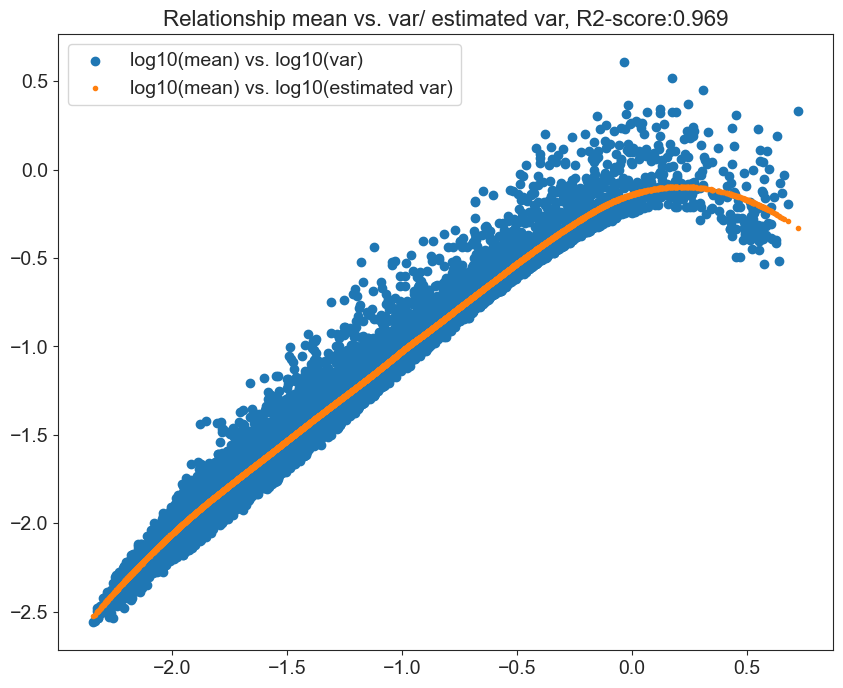

In [7]:
df_mean_var = get_mean_and_variance_gene_expression(
    adata,
    estim_var=True,
    show_plots=True,
    store_path=None,
)

In [8]:
ctrl_size = 100
nr_bins=25

In [9]:
gene_bins = get_bins_wrt_avg_gene_expression(df_mean_var['mean'], nr_bins)

In [10]:
gene_bins.value_counts().sort_index()

0     501
1     501
2     500
3     501
4     501
5     500
6     501
7     500
8     501
9     501
10    500
11    501
12    500
13    501
14    501
15    500
16    501
17    500
18    501
19    501
20    500
21    501
22    500
23    501
24    501
Name: mean, dtype: int64

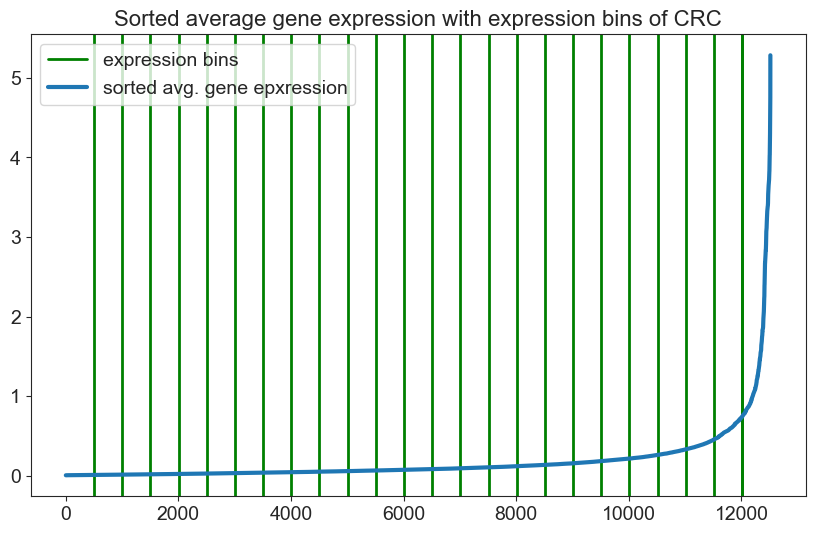

In [11]:
plt.figure(figsize=(10, 6))
for val in np.where(gene_bins.values[:-1] != gene_bins.values[1:])[0]:
    plt.axvline(val, c='g', lw=2)
plt.axvline(val, c='g', lw=2, label='expression bins')

plt.plot(df_mean_var['mean'].values, lw=3, label='sorted avg. gene epxression')
plt.legend(fontsize=14)
plt.title(f'Sorted average gene expression with expression bins of {dataset.upper()}',fontsize=16)
if save:
    plt.savefig(os.path.join(storing_path, f'avg_gene_epxression_{dataset}.svg'),format='svg')
    plt.savefig(os.path.join(storing_path, f'avg_gene_epxression_{dataset}.png'),format='png',dpi=300)
if show:
    plt.show()
else:
    plt.close()

In [12]:
genes_last_bin = gene_bins[gene_bins==24].index.tolist()
len(genes_last_bin)

501

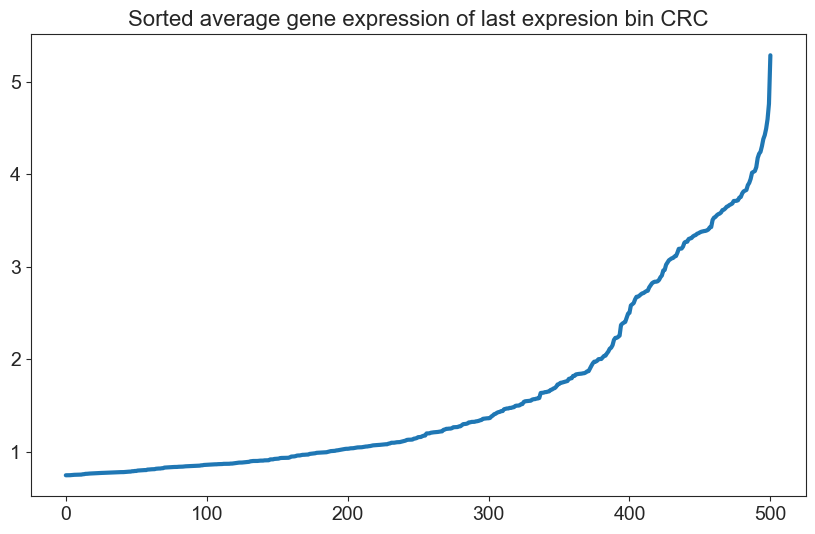

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df_mean_var.loc[genes_last_bin,'mean'].values, lw=3, label='sorted avg. gene epxression')
plt.title(f'Sorted average gene expression of last expresion bin {dataset.upper()}',fontsize=16)
if save:
    plt.savefig(os.path.join(storing_path, f'avg_gene_epxression_in_last_bin_{dataset}.svg'),format='svg')
    plt.savefig(os.path.join(storing_path, f'avg_gene_epxression_in_last_bin_{dataset}.png'),format='png',dpi=300)
if show:
    plt.show()
else:
    plt.close()

In [14]:
df_mean_var.loc[genes_last_bin,'mean']

DEK        0.744845
SEC11A     0.745087
DDIT4      0.745148
PHPT1      0.745661
COX7A2L    0.747213
             ...   
MT-CO3     4.420746
MT-CO2     4.490660
TMSB4X     4.593114
MT-CO1     4.759493
MALAT1     5.284267
Name: mean, Length: 501, dtype: float64

In [15]:
# We remove genes at the boeader for which ANS could not create a valid control set, since we only consider the last expression bin
sig_genes_to_test_for = genes_last_bin[50:-50]

In [16]:
avg_exprs_last_expression_bin = df_mean_var.loc[genes_last_bin,'mean']

In [17]:
avg_exprs_last_expression_bin

DEK        0.744845
SEC11A     0.745087
DDIT4      0.745148
PHPT1      0.745661
COX7A2L    0.747213
             ...   
MT-CO3     4.420746
MT-CO2     4.490660
TMSB4X     4.593114
MT-CO1     4.759493
MALAT1     5.284267
Name: mean, Length: 501, dtype: float64

In [18]:
rows_abs_diff = []

In [19]:
%reload_ext memory_profiler

In [20]:
def ANS_control_genes(ref_genes, avg_expr_sig_gene):
    ref_genes_means = avg_exprs_last_expression_bin[ref_genes]
    ref_genes_means = ref_genes_means.sort_values()
    rolled = ref_genes_means.rolling(ctrl_size, closed='right').mean()
    min_val_idx = np.argmin(((rolled - avg_expr_sig_gene).abs()))
    sig_gene_ctrl_genes = rolled.iloc[(min_val_idx - ctrl_size + 1):min_val_idx + 1]
    return avg_exprs_last_expression_bin[sig_gene_ctrl_genes.index].mean()

In [21]:
Seurat_AG = []
for sig_gene in tqdm(sig_genes_to_test_for):
    
    ref_genes = list(set(avg_exprs_last_expression_bin.index).difference(set([sig_gene])))
    
#     avg_expr_sig_gene = avg_exprs_last_expression_bin[sig_gene]
    # Seurat_AG control genes
    Seurat_AG_mean_control = avg_exprs_last_expression_bin[ref_genes].mean()
#     Seurat_AG.append(np.abs(avg_expr_sig_gene - Seurat_AG_mean_control))
    Seurat_AG.append(Seurat_AG_mean_control)

100%|██████████| 401/401 [00:00<00:00, 2330.96it/s]


In [22]:
ANS = []
for sig_gene in tqdm(sig_genes_to_test_for):
    
    ref_genes = list(set(avg_exprs_last_expression_bin.index).difference(set([sig_gene])))
    
    avg_expr_sig_gene = avg_exprs_last_expression_bin[sig_gene]
    # ANS control genes
    ANS_mean_control = ANS_control_genes(ref_genes, avg_expr_sig_gene)
#     ANS.append(np.abs(avg_expr_sig_gene - ANS_mean_control))
    ANS.append(ANS_mean_control)    

100%|██████████| 401/401 [00:00<00:00, 1242.77it/s]


In [23]:
Seurat = []
for sig_gene in tqdm(sig_genes_to_test_for):
    
    ref_genes = list(set(avg_exprs_last_expression_bin.index).difference(set([sig_gene])))
    
#     avg_expr_sig_gene = avg_exprs_last_expression_bin[sig_gene]
    # Seurat et al. control genes 
    r_genes = ref_genes.copy()
    np.random.shuffle(r_genes)
    Seurat_mean_control = avg_exprs_last_expression_bin[r_genes[:ctrl_size]].mean()
#     Seurat.append(np.abs(avg_expr_sig_gene - Seurat_mean_control))
    Seurat.append(Seurat_mean_control)    

100%|██████████| 401/401 [00:00<00:00, 3367.43it/s]


In [24]:
adata.uns['log1p']['base']=None

In [25]:
least_variable_genes_per_bin = get_least_variable_genes_per_bin_v1(
            adata,
            gene_bins,
            ctrl_size+1,
            method='seurat',
        )

In [26]:
Seurat_LVG = []
for sig_gene in tqdm(sig_genes_to_test_for):
    
    ref_genes = list(set(avg_exprs_last_expression_bin.index).difference(set([sig_gene])))
    
#     avg_expr_sig_gene = avg_exprs_last_expression_bin[sig_gene]
    # LVCGS control genes 
    if len(set(least_variable_genes_per_bin[24]).difference([sig_gene]))==(ctrl_size+1):
        curr_contol = least_variable_genes_per_bin[24][0:-1]
    elif len(set(least_variable_genes_per_bin[24]).difference([sig_gene]))==(ctrl_size):
        curr_contol = list(set(least_variable_genes_per_bin[24]).difference([sig_gene]))
    else:
        raise ValueError
    Seurat_LVG_mean_control = avg_exprs_last_expression_bin[curr_contol].mean()
#     Seurat_LVG.append(np.abs(avg_expr_sig_gene - Seurat_mean_control))
    Seurat_LVG.append(Seurat_LVG_mean_control)

100%|██████████| 401/401 [00:00<00:00, 3328.63it/s]


In [27]:
df = pd.DataFrame({'ANS':ANS, 'Seurat':Seurat, 'Seurat_AG':Seurat_AG, 'Seurat_LVG':Seurat_LVG}, index = sig_genes_to_test_for)
if save:
    df.to_csv(os.path.join(storing_path, f'abs_diffs_control_to_sig_average_expression_{dataset}.csv'))

In [28]:
df.head()

,ANS,Seurat,Seurat_AG,Seurat_LVG
PSMA1,0.798210,1.648047,1.617863,0.924004
MGST3,0.798168,1.692972,1.617854,0.921944
AURKAIP1,0.798155,1.540288,1.617852,0.923949
EIF3L,0.798141,1.552716,1.617849,0.923935
FOSB,0.799280,1.721312,1.617847,0.921944


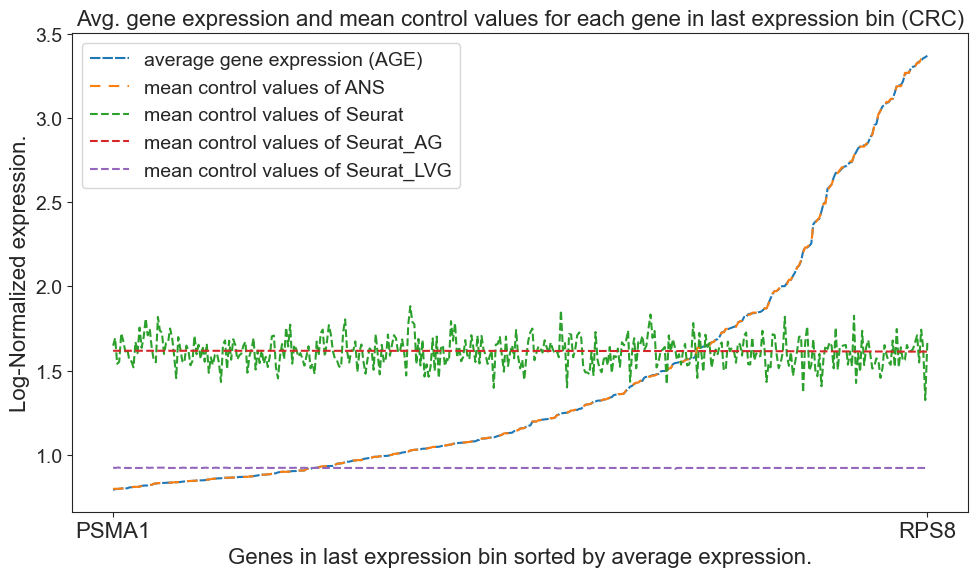

In [29]:
plt.figure(figsize=(10, 6))
avg_exprs_last_expression_bin[sig_genes_to_test_for].plot(label='average gene expression (AGE)', ls=':', dashes=(5, 1))
df['ANS'].plot(label='mean control values of ANS', ls=':', dashes=(5, 4))
df['Seurat'].plot(label='mean control values of Seurat', ls='--')
df['Seurat_AG'].plot(label='mean control values of Seurat_AG', ls='--')
df['Seurat_LVG'].plot(label='mean control values of Seurat_LVG', ls='--')
plt.legend(fontsize=14)
plt.title(f'Avg. gene expression and mean control values for each gene in last expression bin ({dataset.upper()})', fontsize=16);
plt.xlabel('Genes in last expression bin sorted by average expression.', fontsize=16);
plt.xticks((plt.gca().get_xticks()[[1, -2]]),
          [plt.gca().get_xticklabels()[1], plt.gca().get_xticklabels()[-2]], fontsize=16);
plt.ylabel('Log-Normalized expression.', fontsize=16);
plt.tight_layout()

if save:
    plt.savefig(os.path.join(storing_path, f'abs_diffs_control_to_sig_average_expression_{dataset}.png'), dpi=300)
    plt.savefig(os.path.join(storing_path, f'abs_diffs_control_to_sig_average_expression_{dataset}.svg'))

if show:
    plt.show()
else:
    plt.close()